In [3]:
%matplotlib inline
import os, collections
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import fisher_exact, spearmanr
from statsmodels.stats.multitest import fdrcorrection

rawData_path = "/home/jingbozhou/Project/CombDrug/runAddMut/9-plot/rawData/"
pathway_path = "/home/jingbozhou/Project/CombDrug/runAddMut/9-plot/1-NumberofData/drugPath/"

In [5]:
### 1. Read drug combination data
raw_data = pd.read_table(os.path.join(rawData_path, "all_comb_data.tsv"))

## 1-1 drug pathway
drug_path = pd.read_csv(os.path.join(pathway_path, "drug_pathway.csv"), index_col="Drug_name").to_dict()['Pathway']
raw_data["Drug_row_path"] = raw_data["Drug_row"].map(drug_path)
raw_data["Drug_col_path"] = raw_data["Drug_col"].map(drug_path)

data_ZIP = pd.read_table(os.path.join(pathway_path, "data_ZIP.tsv"))


all_data = raw_data.merge(data_ZIP[["DrugComb_id", "Comb_pathway"]], 
                          left_on="DrugComb_id", right_on="DrugComb_id")

RTK signaling+PI3K/MTOR signaling ZIP 13.67% 2.17% 11.50%
RTK signaling+PI3K/MTOR signaling Bliss 17.65% 3.58% 14.06%
RTK signaling+PI3K/MTOR signaling Loewe 13.49% 2.14% 11.36%
RTK signaling+PI3K/MTOR signaling HSA 23.01% 3.64% 19.37%


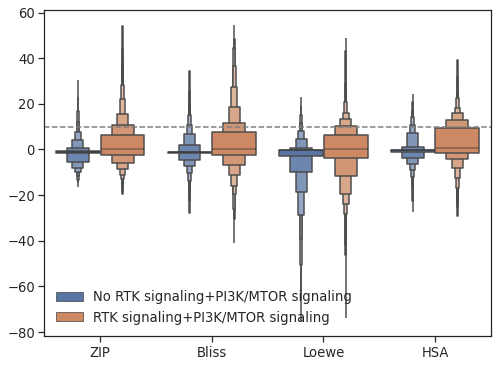

In [6]:
cancer_type = "Breast Cancer"
comb_path = "RTK signaling+PI3K/MTOR signaling"

data_sel = all_data[all_data["primary_disease"]==cancer_type].copy()
data_sel.loc[(data_sel["Comb_pathway"]==comb_path), "Type"] = comb_path
data_sel.loc[(data_sel["Comb_pathway"]!=comb_path), "Type"] = "No {}".format(comb_path)

data_long = data_sel[['ZIP', 'Bliss', 'Loewe', 'HSA', 'Type']].melt(id_vars='Type', 
                                                                    value_vars=['ZIP', 'Bliss', 'Loewe', 'HSA'], 
                                                                    var_name="Synergy_metrics", 
                                                                    value_name='Value')

#data_long["Value"] = np.log(data_long["Value"])

sns.set(font_scale=1.2, rc={'figure.figsize':(8, 6)}, style="ticks")

#g = sns.violinplot(data=data_long, x="Synergy_metrics", y="Value", hue='Type', inner="quartile", cut=0)

ax = sns.boxenplot(data=data_long, x="Synergy_metrics", y="Value", hue='Type', 
                  k_depth="proportion", outlier_prop=0.01, showfliers=False)

ax.axhline(y=10, linestyle='--', color='#7d7d7d', linewidth=1.5)

ax.set(xlabel="", ylabel="")
ax.legend(frameon=False, loc=3)
#handles, labels = ax.get_legend_handles_labels()
        
#ax.legend(handles=handles[:2],
              #labels=["No", "Yes"],
              #loc=4,
              #title=feat_name)

#ax.spines.right.set_visible(False)
#ax.spines.top.set_visible(False)

#plt.savefig('./plotFigure/breast_RTK_MTOR.svg', format='svg',bbox_inches='tight', transparent=True)

for syn_score in ['ZIP', 'Bliss', 'Loewe', 'HSA']:
    data_long_sel = data_long[data_long["Synergy_metrics"]==syn_score]
    
    syn_in = (data_long_sel[data_long_sel["Type"]==comb_path]["Value"]>10).sum()
    no_in = (data_long_sel[data_long_sel["Type"]==comb_path]["Value"]<=10).sum()
    syn_out = (data_long_sel[data_long_sel["Type"]!=comb_path]["Value"]>10).sum()
    no_out = (data_long_sel[data_long_sel["Type"]!=comb_path]["Value"]<=10).sum()
    #fisher_exact([[syn_in, syn_out], #[no_in, no_out]], 
    #alternative="greater")
    
    syn_in_per = syn_in / (syn_in+no_in)
    syn_out_per = syn_out / (syn_out+no_out)
    print(comb_path, syn_score, 
          "{:.2f}%".format(syn_in_per*100), 
          "{:.2f}%".format(syn_out_per*100), 
          "{:.2f}%".format((syn_in_per-syn_out_per)*100))